# XGBoost (Dataset 3d)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from rdkit import DataStructs

/home/notebook/Documents/Workspace/Python/TP-Jupyter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor and Outlier Functions

In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def smiles_to_rdkit_fp(smiles, n_bits=256):
    # Molecule from SMILES
    mol, state = molecule_from_smiles(smiles)

    # If molecule is none
    if mol is None:
        return np.zeros(n_bits, dtype=int)

    # Compute RDKit fingerprint
    fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


## Dataset Processing

In [3]:
# Configuration
ORIG_DATASET = "datasets/in_vitro_3d_dataset_homolumo_processed.xlsx"
SKIP_ROWS = 0
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
HOMO_COL = "HOMO_eV"
LUMO_COL = "LUMO_eV"
HL_GAP_COL = "HL_Gap_eV"
FULL_OUTPUT_DATASET = "3d_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.90
# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Add HOMO/LUMO/HL_Gap columns
extra_cols = [HOMO_COL, LUMO_COL, HL_GAP_COL]

descriptor_data_all[extra_cols] = dataset[extra_cols].reset_index(drop=True)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

# Calculate fingerprint - added after all of processing
n_bits = 256
smiles_series = dataset_ok[SMILES_COL].astype(str)

fp_list = [smiles_to_rdkit_fp(s, n_bits=n_bits) for s in smiles_series]
fp_array = np.vstack(fp_list)

fp_cols = [f"RDKit_fp_{i}" for i in range(n_bits)]
fps_full = pd.DataFrame(fp_array, columns=fp_cols, index=dataset_ok.index)

# Align fingerprints with train/test indices
fp_train = fps_full.loc[X_train.index]
fp_test = fps_full.loc[X_test.index]

Full - Rows: 119/Columns: 236
                           Name                        IUPAC name CAS registry number Structure  Phototoxicity                  SMILES code                             Source  Unnamed: 7                             Unnamed: 8             NOTES  Unnamed: 10 Unnamed: 11  HOMO_eV  LUMO_eV  HL_Gap_eV MoleculeStatus  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0    Chi0n    Chi0v     Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha         Ipc    Kappa1   Kappa2   Kappa3  LabuteASA  PEOE_VSA1  PEOE_VSA10  PEOE_VSA11  PEOE

## Base Model Train

In [4]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.6667
Precision: 0.6250
Recall:    0.5556
F1 score:  0.5882
ROC AUC:   0.7593

Classification report:
              precision    recall  f1-score   support

           0      0.692     0.750     0.720        12
           1      0.625     0.556     0.588         9

    accuracy                          0.667        21
   macro avg      0.659     0.653     0.654        21
weighted avg      0.663     0.667     0.664        21



## Feature Selection

PermutationExplainer explainer: 84it [00:10, 10.01s/it]                
/tmp/ipykernel_60291/335949761.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


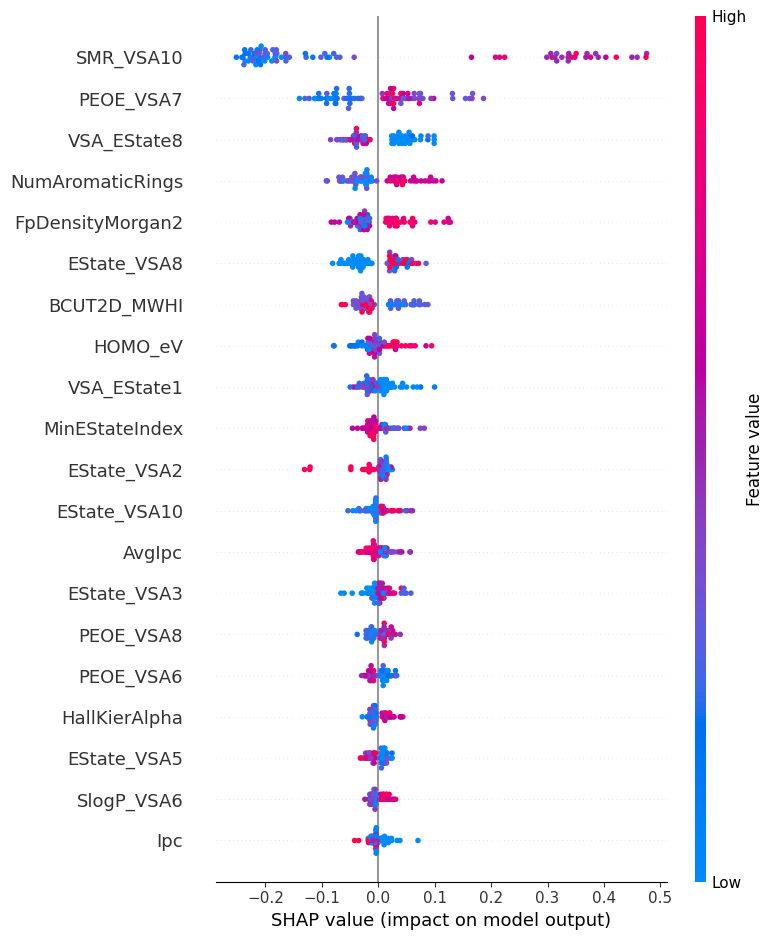

In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

In [6]:
shap_features.head(30)

SMR_VSA10           0.237384
PEOE_VSA7           0.066866
VSA_EState8         0.044859
NumAromaticRings    0.043433
FpDensityMorgan2    0.039664
EState_VSA8         0.038297
BCUT2D_MWHI         0.033492
HOMO_eV             0.022872
VSA_EState1         0.019545
MinEStateIndex      0.017893
EState_VSA2         0.015964
EState_VSA10        0.014503
AvgIpc              0.014093
EState_VSA3         0.013960
PEOE_VSA8           0.013705
PEOE_VSA6           0.013544
HallKierAlpha       0.013107
EState_VSA5         0.012642
SlogP_VSA6          0.010905
Ipc                 0.010850
HL_Gap_eV           0.009822
VSA_EState2         0.009223
Kappa2              0.008558
MolWt               0.006751
MaxPartialCharge    0.006187
BCUT2D_MWLOW        0.006078
BCUT2D_MRLOW        0.005584
PEOE_VSA10          0.005012
SlogP_VSA3          0.004787
BalabanJ            0.004694
dtype: float64

In [7]:
xgb_features.head(30)

SMR_VSA10           0.108883
EState_VSA10        0.098858
MolWt               0.098580
AvgIpc              0.096828
VSA_EState1         0.052705
NumAromaticRings    0.033211
EState_VSA7         0.032700
BCUT2D_MRLOW        0.031910
fr_allylic_oxid     0.027903
BCUT2D_MWLOW        0.026699
FpDensityMorgan3    0.023849
PEOE_VSA7           0.023528
Ipc                 0.022294
BalabanJ            0.020817
Kappa3              0.020109
HOMO_eV             0.018794
EState_VSA2         0.018191
TPSA                0.017820
VSA_EState6         0.016786
VSA_EState5         0.014848
EState_VSA3         0.014184
BCUT2D_MRHI         0.013996
SlogP_VSA8          0.013887
MaxPartialCharge    0.013763
MinEStateIndex      0.013398
FpDensityMorgan2    0.012337
SlogP_VSA3          0.011880
HL_Gap_eV           0.009964
VSA_EState2         0.009193
VSA_EState3         0.007096
dtype: float32

In [8]:
kbest_features.head(30)

SMR_VSA10                  30.606611
NumAromaticRings           28.331059
RingCount                  21.684124
fr_bicyclic                18.546225
SlogP_VSA8                 17.773131
NumAromaticHeterocycles    16.791965
BertzCT                    13.946273
fr_ether                   12.755029
fr_aniline                 12.726220
PEOE_VSA8                  11.759629
SMR_VSA7                   11.139319
BCUT2D_MRHI                10.794104
NumHeterocycles            10.641572
SMR_VSA3                   10.337933
SlogP_VSA6                 10.177819
BCUT2D_MRLOW                9.644366
fr_COO                      9.363487
fr_NH1                      8.879176
fr_Ar_N                     8.658055
HOMO_eV                     8.259408
PEOE_VSA7                   7.537158
SlogP_VSA10                 7.438316
fr_NH0                      7.371403
fr_methoxy                  7.131864
SlogP_VSA3                  7.114178
NumAromaticCarbocycles      6.831060
SlogP_VSA1                  6.406299
f

In [9]:
lasso_features.head(30)

PEOE_VSA3            0.806981
PEOE_VSA11           0.606361
EState_VSA9          0.560245
SMR_VSA1             0.512907
VSA_EState6          0.508852
VSA_EState3          0.482391
PEOE_VSA10           0.435843
SMR_VSA10            0.409841
PEOE_VSA6            0.363436
SlogP_VSA3           0.358490
PEOE_VSA12           0.282085
EState_VSA5          0.275459
EState_VSA7          0.219418
SlogP_VSA4           0.207285
SMR_VSA4             0.174469
EState_VSA3          0.172768
MaxAbsEStateIndex    0.172626
BCUT2D_MWHI          0.168678
VSA_EState1          0.157839
VSA_EState2          0.156659
SlogP_VSA11          0.130383
EState_VSA8          0.129602
SlogP_VSA12          0.127870
PEOE_VSA7            0.126620
SlogP_VSA5           0.114505
SlogP_VSA10          0.085158
SMR_VSA6             0.071944
EState_VSA1          0.060115
EState_VSA2          0.057414
PEOE_VSA9            0.053134
dtype: float64

## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===


Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.714 | ROC-AUC: 0.713

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Accuracy: 0.714 | ROC-AUC: 0.713

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.741

=== Testing top 8 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.704

=== Testing top 9 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.619 | ROC-AUC: 0.741

=== Testing top 10 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 30, 'max_depth': 6, 'learn

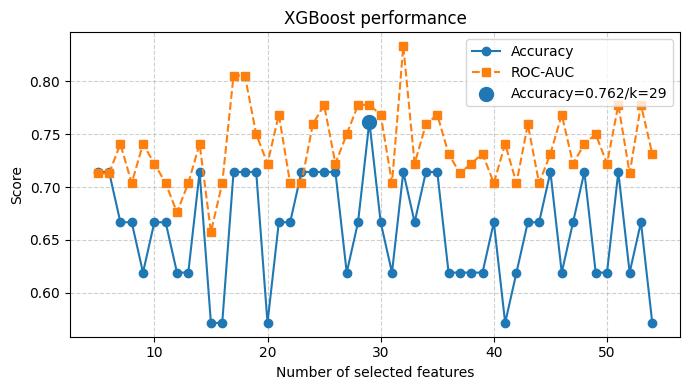


Accuracy = 0.762/ROC-AUC = 0.778/k = 29


In [10]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model SHAP Features Tuning (Randomized Search CV) - Fingerprint

In [11]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 29 features: 29 selected.
Final train shape with fingerprints: (83, 285)
Final test shape with fingerprints:  (21, 285)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.6, 'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Test Accuracy: 0.714
Test ROC-AUC: 0.676


## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.619 | ROC-AUC: 0.657

=== Testing top 6 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 70, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.571 | ROC-AUC: 0.685

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Accuracy: 0.667 | ROC-AUC: 0.667

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.571 | ROC-AUC: 0.667

=== Testing top 9 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.619 | ROC-AUC: 0.713

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_esti

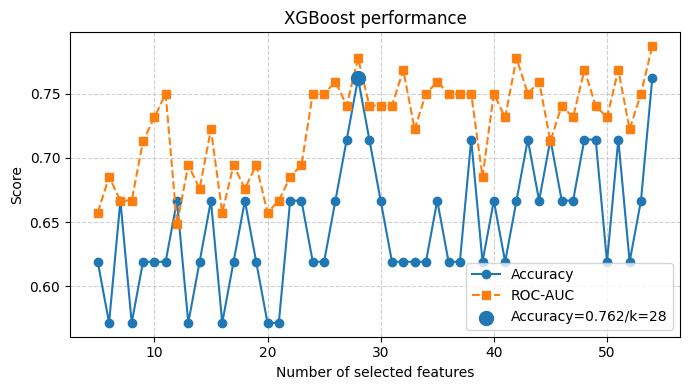


Accuracy = 0.762/ROC-AUC = 0.778/k = 28


In [12]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV) - Fingerprint

In [13]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 28 features: 28 selected.
Final train shape with fingerprints: (83, 284)
Final test shape with fingerprints:  (21, 284)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Test Accuracy: 0.571
Test ROC-AUC: 0.731


## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Accuracy: 0.524 | ROC-AUC: 0.676

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.616

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.619 | ROC-AUC: 0.606

=== Testing top 8 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.619 | ROC-AUC: 0.704

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.571 | ROC-AUC: 0.694

=== Testing top 10 features ===
Best parameters: {'subsample': 0.8, 'n_est

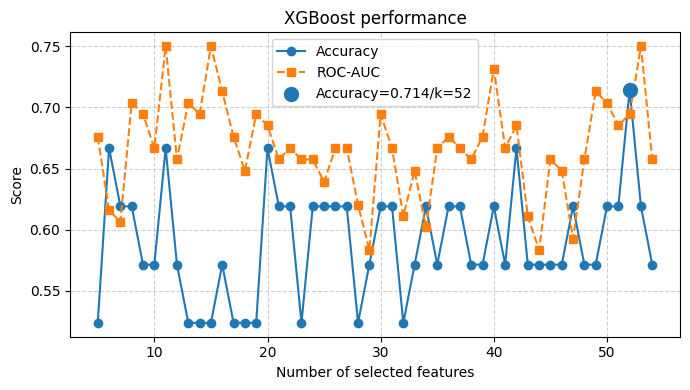


Accuracy = 0.714/ROC-AUC = 0.694/k = 52


In [14]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV) - Fingerprint

In [15]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 52 features: 52 selected.
Final train shape with fingerprints: (83, 308)
Final test shape with fingerprints:  (21, 308)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.9, 'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Test Accuracy: 0.524
Test ROC-AUC: 0.620


## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.714 | ROC-AUC: 0.833

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.762 | ROC-AUC: 0.870

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.856

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Accuracy: 0.524 | ROC-AUC: 0.699

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 30, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Accuracy: 0.619 | ROC-AUC: 0.713

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_estima

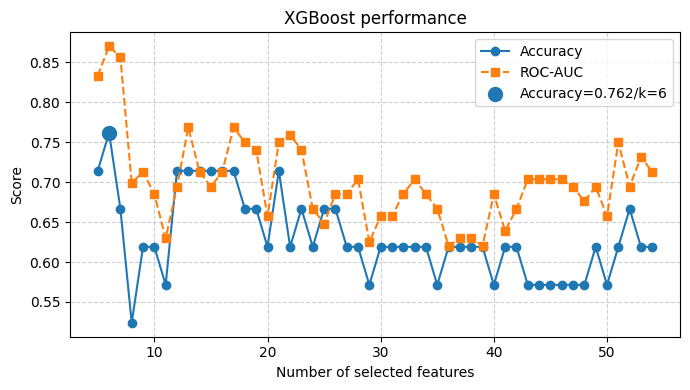


Accuracy = 0.762/ROC-AUC = 0.870/k = 6


In [16]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV) - Fingerprint

In [17]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 6 features: 6 selected.
Final train shape with fingerprints: (83, 262)
Final test shape with fingerprints:  (21, 262)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Test Accuracy: 0.762
Test ROC-AUC: 0.704
